# Linear regression single non-numeric feature 
## One-Hot encoding

This notebook contains code to train and evaluate a linear regression model using a single non-numeric feature and label.

The technique we will use to handle the non-numeric features is called [One-Hot encoding](https://en.wikipedia.org/wiki/One-hot)

Import the required python libraries
- **pandas** contains the dataframe object and a number of useful methods for manipulating and querying data contained in a dataframe
- **numpy** contains a number of useful mathematical operations including some that are helpful when evaluating accuracy of trained models
- **Scikitlearn train_test_split** splits data into training and test sets
- **scikitlearn LinearRegression** used to train a linear regression model
- **scikitlearn metrics** used to calculate metrics such as Mean Squared Error, helpful when evaluating accuracy of trained models
- **matplotlib pyplot** used to plot graphs

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
#import statsmodels.api as sm
import matplotlib.pyplot as plt

Read flight data from csv file into Pandas dataframe

In [2]:
flight_df=pd.read_csv('all_flights.csv') # Read csv file into flight_df dataframe
flight_df.shape                          # Display shape of array to see how many rows and columns are in the dataframe

(616101, 17)

Display the first 10 rows in the dataset to make sure data looks like it imported correctly

In [3]:
flight_df.head()                         # Displays the top 10 rows from flight_df dataframe

,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,Unnamed: 16
0,2018-10-01,WN,N221WN,802,ABQ,BWI,905,903.0,-2.0,1450,1433.0,-17.0,225.0,210.0,197.0,1670.0,NaN
1,2018-10-01,WN,N8329B,3744,ABQ,BWI,1500,1458.0,-2.0,2045,2020.0,-25.0,225.0,202.0,191.0,1670.0,NaN
2,2018-10-01,WN,N920WN,1019,ABQ,DAL,1800,1802.0,2.0,2045,2032.0,-13.0,105.0,90.0,80.0,580.0,NaN
3,2018-10-01,WN,N480WN,1499,ABQ,DAL,950,947.0,-3.0,1235,1223.0,-12.0,105.0,96.0,81.0,580.0,NaN
4,2018-10-01,WN,N227WN,3635,ABQ,DAL,1150,1151.0,1.0,1430,1423.0,-7.0,100.0,92.0,80.0,580.0,NaN


Display the names of the columns in the dataframe and their datatypes

In [4]:
flight_df.dtypes  # Displays the names and data types of the columns in the dataframe

FL_DATE                 object
OP_UNIQUE_CARRIER       object
TAIL_NUM                object
OP_CARRIER_FL_NUM        int64
ORIGIN                  object
DEST                    object
CRS_DEP_TIME             int64
DEP_TIME               float64
DEP_DELAY              float64
CRS_ARR_TIME             int64
ARR_TIME               float64
ARR_DELAY              float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
Unnamed: 16            float64
dtype: object

Create a new dataframe containing ONLY the columns we want to use as features and labels.
This saves us spending time cleaning up data we are not using to train our model.
This model will use OP_UNIQUE_CARRIER (the airline operating the flight) as a feature to predict the value of the label ARR_DELAY

In [6]:
min_flight_data_df = flight_df[['OP_UNIQUE_CARRIER','ARR_DELAY']] # Create a new dataframe containing only
                                                                  # OP_UNIQUE_CARRIER and ARR_DELAY
min_flight_data_df.shape                                          # Display the shape of the dataframe as a quick check to 
                                                                  # ensure dataframe has expected number of columns and rows

(616101, 2)

Get rid of rows containing NaN/missing values

In [7]:
no_missing_values_df = min_flight_data_df.dropna(axis=0,how='any')  # Use dropna to remove rows with NaN in any column
no_missing_values_df.shape                                          # Display shape to see how many rows were removed

(610334, 2)

Let's take a closer look at our data and find out how many flights we have from each carrier

In [8]:
no_missing_values_df.groupby('OP_UNIQUE_CARRIER')['ARR_DELAY'].count()

OP_UNIQUE_CARRIER
9E     20819
AA     78092
AS     21396
B6     24716
DL     81950
EV     14993
F9     10320
G4      7559
HA      7137
MQ     25548
NK     13725
OH     23459
OO     66063
UA     55388
WN    113840
YV     18728
YX     26601
Name: ARR_DELAY, dtype: int64

We can also use a graph to display the number of flights by each carrier visually

Text(0, 0.5, 'Nbr Flights')

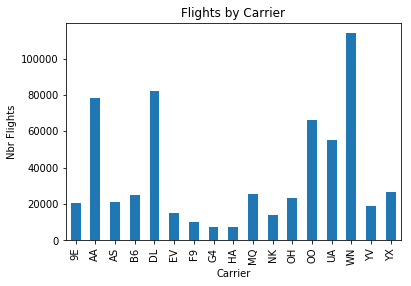

In [11]:
ax = no_missing_values_df.groupby('OP_UNIQUE_CARRIER')['ARR_DELAY'].count().plot(kind='bar', title='Flights by Carrier')
ax.set_xlabel('Carrier')
ax.set_ylabel('Nbr Flights')

Continuing to explore our data, let's check the average delay time by carrier to see if there is any correlation between carriers and arrival delay

In [8]:
no_missing_values_df.groupby('OP_UNIQUE_CARRIER')['ARR_DELAY'].mean()

OP_UNIQUE_CARRIER
9E     1.074403
AA     6.403908
AS     0.992008
B6     4.337797
DL    -3.546894
EV    10.948643
F9    13.964922
G4     4.158883
HA    -0.595208
MQ     2.816541
NK    -2.920583
OH     0.657530
OO     3.772550
UA     3.397740
WN     1.927837
YV    14.740709
YX     1.803992
Name: ARR_DELAY, dtype: float64

Let's display that same data visually in a graph

Text(0, 0.5, 'Average Flight Delay')

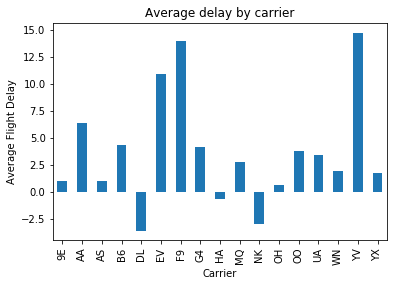

In [12]:
ax=no_missing_values_df.groupby('OP_UNIQUE_CARRIER')['ARR_DELAY'].mean().plot(kind='bar',title='Average delay by carrier')
ax.set_xlabel('Carrier')
ax.set_ylabel('Average Flight Delay')

There does seem to be a relation between carrier and delay times. So maybe I can train a model using OP_UNIQUE_CARRIER as a feature.

OP_UNIQUE_CARRIER is not numeric so I need to make it numeric, basically I want to know iif a flight is operated by a particular airline is it more likely to be late. 

I need to make a dummy column for each possible airline i.e. AIRCANADA 1/0 WESTJET 1/0 AIRTRANSAT 1/0 for every row. a value of 1 means the flight was operated by that carrier. Then I can include those columns as features when I train my model.

The *[get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)* method in pandas will return a dataframe of dummy columns for a given column.

This particular technique for converting string to numeric data by creating dummy columns for each possible value and specifying a 1 or 0 to indicate which rows contain which value is called one-hot encoding.

In [14]:
dummy_df = pd.get_dummies(no_missing_values_df['OP_UNIQUE_CARRIER'])
dummy_df.head

<bound method NDFrame.head of         9E  AA  AS  B6  DL  EV  F9  G4  HA  MQ  NK  OH  OO  UA  WN  YV  YX
0        0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0
1        0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0
2        0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0
3        0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0
4        0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
616096   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0
616097   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0
616098   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0
616099   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0
616100   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0

[610334 rows x 17 columns]>

Create one dataframe containing only the features OP_UNIQUE_CARRIER dummy columns, and one dataframe containing only the label (ARR_DELAY) 
If either of these has only one column you must reshape the dataframe to -1,1

In [15]:
# Create a dataFrame containing the feature columns
X = dummy_df

In [16]:
# Create a DataFrame containing the labels
# Reshape to -1,1 if only containing a single column
y = no_missing_values_df['ARR_DELAY'].values.reshape(-1,1)

Split the data into two datasets, one for training the model, one for testing the model

scikitlearn method [train_test_split]( 
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) 
- **X** is the dataframe containing our features
- **Y** is the dataframe containing our label
- **test_size** determines what fraction of the data is put into the test dataframe
- **random_state** defaults to a random number, by specifying a specific number I ensure the split I generate is reproducible. That way if I make changes I know changes in accuracy are not caused by different rows used as training or test data.

In [18]:
#Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=42)

Check the size of your test and training datasets (i.e. how many rows in each)

In [19]:
X_train.shape

(427233, 17)

In [20]:
X_test.shape

(183101, 17)

Train the model using scikitlearn [LinearRegression]( 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

Your feature must be numeric that's why we created the dummy columns for OP_UNIQUE_CARRIER

Your training data cannot contain any missing values in rows.

In [22]:
regressor = LinearRegression()     # Create a scikit learn LinearRegression object
regressor.fit(X_train, y_train)    # Use the fit methong to train the model using your training data

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Let's see what arrival delays are predicted for our test data by using the **predict** method of our linearRegression object

In [24]:
y_pred = regressor.predict(X_test)

Let's compare the actual arrival delay times and the predicted arrival delay times

In [25]:
#combine the two 1D numpy arrays into a 2D array
combined = np.hstack((y_test,y_pred))
#Convert to a DataFrame
accuracy_df = pd.DataFrame(combined,columns=['Actual','Predicted'])
accuracy_df.head

<bound method NDFrame.head of         Actual  Predicted
0        -13.0  -3.507225
1        -24.0  14.829079
2        100.0   6.300830
3         -8.0   0.796358
4        -19.0  13.776355
...        ...        ...
183096    48.0   1.357497
183097   -24.0   1.921001
183098    20.0   1.939634
183099    47.0  14.829079
183100   -11.0   1.939634

[183101 rows x 2 columns]>

We can do some calculations to get a sense of overall accuracy

In [32]:
print('Mean absolute error: ',metrics.mean_absolute_error(y_test,y_pred))

Mean absolute error:  20.10786357633716


print('Mean Squared Error:', metrics.mean_squared_error(y_test,y_pred))

In [34]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

Root Mean Squared Error: 41.91637637662109


Check coefficients for our attributes

In [46]:
print(regressor.coef_)
print(X_train.columns)

[[-7.66451618e+09 -7.66451618e+09 -7.66451618e+09 -7.66451618e+09
  -7.66451619e+09 -7.66451617e+09 -7.66451617e+09 -7.66451618e+09
  -7.66451619e+09 -7.66451618e+09 -7.66451619e+09 -7.66451618e+09
  -7.66451618e+09 -7.66451618e+09 -7.66451618e+09 -7.66451617e+09
  -7.66451618e+09]]
Index(['9E', 'AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'G4', 'HA', 'MQ', 'NK', 'OH',
       'OO', 'UA', 'WN', 'YV', 'YX'],
      dtype='object')


These are **very** small numbers so it does not appear there is a strong correlation between airline and number of minutes late for the flight.